In [1]:
# Import all the necessary packages
import os
import numpy as np 
import tensorflow as tf
import json
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
# import regarding database handles
import db_classes as orm
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [31]:
import graph_construction as gc
import random

In [4]:
# File locations for specific files.
graph_file_path = '/mnt/8tb/csenrc/representation_learning_codes/graph_file.json'
index_file_path = '/mnt/8tb/csenrc/representation_learning_codes/index_file.json'
# use the database connection URL if needed.
connection_url = 'postgresql+psycopg2://csephase2:csephase@@localhost/darpa_tc3'

In [6]:
# Let's load the graph first. 

provenance_graph = json.load(open(graph_file_path))
print("Number of subjects in the graph: {}".format(len(provenance_graph)))

Number of subjects in the graph: 224146


In [37]:
# Please note that the graph loading time is obnoxiously large. 
# Therefore, at this point, please refrain from doing anything that needs loading the graph from file multiple times.

max_len = -1
min_len = 1000000000000
largest_subject_subgraph = -1
smallest_subject_subgraph = -1
count = 0
small_graphs = []

for subject in provenance_graph:
    if len(provenance_graph[subject]['events']) > max_len:
        max_len = len(provenance_graph[subject]['events'])
        largest_subject_subgraph = subject
    if len(provenance_graph[subject]['events']) < min_len:
        min_len = len(provenance_graph[subject]['events'])
        smallest_subject_subgraph = subject
    if len(provenance_graph[subject]['events']) < 32:
        count += 1
        small_graphs.append(subject)  
        

In [38]:
print("Currently the largest subgraph is rooted at subject {} has the size of: {}".format(largest_subject_subgraph, max_len))
print("Currently the smallest subgraph is rooted at subject {} has the size of: {}".format(smallest_subject_subgraph, min_len))
print("Currently number of small subgraph is {}".format(count))

Currently the largest subgraph is rooted at subject 74188 has the size of: 3049408
Currently the smallest subgraph is rooted at subject 4 has the size of: 1
Currently number of small subgraph is 124874


In [9]:
# Wow that is a lot of events for a node. 
# Makes me wonder what a histogram for this data will look like. 
# In other words, what ate the node densities in the graoh. 
# Let's try it out. 

lengths = [] # Simple list will do, we are not tracking, we just want to see the distribution. 

for subject in provenance_graph:
    lengths.append(len(provenance_graph[subject]['events']))

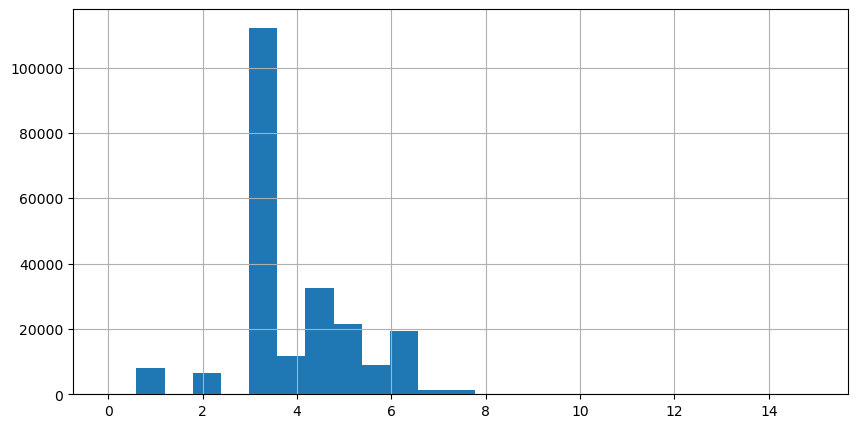

In [30]:
# Now, let's plot the histogram. 
n_bins = 25

plt.figure(figsize=(10,5))
# We can set the number of bins with the *bins* keyword argument.
#plt.scatter(np.arange(len(lengths)),np.log(lengths), marker='.')
plt.hist(np.log(lengths), bins=n_bins)
plt.grid(True)
plt.show()

# Okay, that does not look great at all. 
A lot of nodes have more than 10^(3 to 6) number of events. Which means the timestamp difference varies wildly and plain normalization may not be an option anymore. Therefore, we resort to sinusoidal coding like the original BERT paper. 
# So, the question becomes how do we generate paths now. 
Well, here is another interesting situation. We can subsample the stream of events to generate the paths. But again, the question is now how do we encode the subject information in the path. 

In [49]:
max_time_delta = 0
max_sub_origin =  -1
max_event_stamp = -1
max_sub = -1

min_time_delta = 100000000000000
min_sub_origin =  -1
min_event_stamp = -1
min_sub = -1
negative_count = 0
total_count = 0

for subject in provenance_graph:
    subject_timestamp = provenance_graph[subject]['sub'][2]
    event_list = provenance_graph[subject]['events']
    total_count += len(event_list)
    if subject_timestamp != 0:
        for event in event_list:
            if event[0][3] != 0:
                time_delta = event[0][3] - subject_timestamp

                if time_delta<=0:
                    negative_count +=1 
            
                if time_delta > max_time_delta:    
                    max_time_delta = time_delta
                    max_sub_origin = subject_timestamp
                    max_event_stamp = event[0][3]
                    max_sub = subject

                if time_delta < min_time_delta:
                    min_time_delta = time_delta
                    min_sub_origin = subject_timestamp
                    min_event_stamp = event[0][3]
                    min_sub = subject
        
print("Max time delta: {}, max_sub_origin: {}, max_event_stamp = {}, max_sub = {}".format(max_time_delta, max_sub_origin, max_event_stamp, max_sub))
print("Min time delta: {}, min_sub_origin: {}, min_event_stamp = {}, min_sub = {}".format(min_time_delta, min_sub_origin, min_event_stamp, min_sub))
print("Negative count: {}, pct: {}".format(negative_count, (negative_count/total_count)*100))


Max time delta: 270997933817167, max_sub_origin: 1522759935112293459, max_event_stamp = 1523030933046110626, max_sub = 10623
Min time delta: -10001641, min_sub_origin: 1523218713175536589, min_event_stamp = 1523218713165534948, min_sub = 121235
Negative count: 2819176, pct: 6.827477012164842


### Looks like 6.82% events are have negative time delta which is not possible for us to use. In this case, the ususal approach is to drop the data points. 

In [50]:
cleaned_provenance_graph = dict() # Pruned graph object
remove_count = 0 # Number of events that have been removed from the graph
keep_count = 0 # Number of events that have been retained from the graph

for subject in provenance_graph:

    cleaned_provenance_graph[subject] = dict()
    cleaned_provenance_graph[subject]['sub'] = provenance_graph[subject]['sub'] # Saving the subject identity.
    
    subject_timestamp = provenance_graph[subject]['sub'][2]
    event_list = provenance_graph[subject]['events'] 
    temp_event_list = []
    for event in event_list:
        if event[0][3] != 0:
            time_delta = event[0][3] - subject_timestamp
            if time_delta>0:
                temp_event_list.append(event)
            else:
                remove_count +=1
        else:
            remove_count+=1 

    cleaned_provenance_graph[subject]['events'] = temp_event_list
    keep_count += len(temp_event_list)
    
print("Number of events kept: {}, number of events removed: {}, percentage: {}".format(keep_count, remove_count, ((100*remove_count)/(remove_count+keep_count) )))

Number of events kept: 38472446, number of events removed: 2819176, percentage: 6.827477012164841


In [51]:
# Running the same code block on the pruned provenance graph
max_time_delta = 0
max_sub_origin =  -1
max_event_stamp = -1
max_sub = -1

min_time_delta = 100000000000000
min_sub_origin =  -1
min_event_stamp = -1
min_sub = -1
negative_count = 0
total_count = 0

for subject in cleaned_provenance_graph:
    subject_timestamp = cleaned_provenance_graph[subject]['sub'][2]
    event_list = cleaned_provenance_graph[subject]['events']
    total_count += len(event_list)
    if subject_timestamp != 0:
        for event in event_list:
            if event[0][3] != 0:
                time_delta = event[0][3] - subject_timestamp

                if time_delta<=0:
                    negative_count +=1 
            
                if time_delta > max_time_delta:    
                    max_time_delta = time_delta
                    max_sub_origin = subject_timestamp
                    max_event_stamp = event[0][3]
                    max_sub = subject

                if time_delta < min_time_delta:
                    min_time_delta = time_delta
                    min_sub_origin = subject_timestamp
                    min_event_stamp = event[0][3]
                    min_sub = subject
        
print("Max time delta: {}, max_sub_origin: {}, max_event_stamp = {}, max_sub = {}".format(max_time_delta, max_sub_origin, max_event_stamp, max_sub))
print("Min time delta: {}, min_sub_origin: {}, min_event_stamp = {}, min_sub = {}".format(min_time_delta, min_sub_origin, min_event_stamp, min_sub))
print("Negative count: {}, pct: {}".format(negative_count, (negative_count/total_count)*100))


Max time delta: 270997933817167, max_sub_origin: 1522759935112293459, max_event_stamp = 1523030933046110626, max_sub = 10623
Min time delta: 1472570, min_sub_origin: 1523556159254718787, min_event_stamp = 1523556159256191357, min_sub = 200097
Negative count: 0, pct: 0.0


In [60]:
MAX_TIME_DELTA = 270997933817167
NUMERATOR = np.pi * 0.5 * (1/MAX_TIME_DELTA)
print(NUMERATOR)
print(np.sin(NUMERATOR*MAX_TIME_DELTA))

5.796340601824141e-15
1.0


In [115]:
def get_random_sequence(subject_id, encoding = None, sequence_size = 31 ):
    
    subject_start_time_stamp = cleaned_provenance_graph[subject_id]['sub'][2]
    events = cleaned_provenance_graph[subject_id]['events']
    sampled_events = None
    
    if len(events)>sequence_size:
        sampled_events = random.sample(events, k=sequence_size)
    else:
        sampled_events = events

    sampled_events = sorted(sampled_events, key=lambda x:x[0][3])

    result_array = np.zeros((sequence_size*8)+2)
    index = 2
    
    for event in sampled_events:
        temp = np.zeros(8)

        temp[0] = event[0][0] # Normalized event type
        temp[1] = event[0][1] # Normalized predicate object 1 type
        temp[2] = event[0][2] # Normalized predicate object 2 type
        temp[3] = event[0][4] # Normalized event name

        if event[1] is not None:
            temp[4] = event[1][0] # Details of predicate object 1 if available
            temp[5] = event[1][1] 
        if event[2] is not None:
            temp[6] = event[2][0] # Details of predicate object 2 if available
            temp[7] = event[2][1]
        
        
        time_delta = event[0][3] - subject_start_time_stamp 

        if encoding == 'sine':
            result_array[index:index+8] = temp * np.sin(NUMERATOR * time_delta)
        elif encoding == 'cosine':
            result_array[index:index+8] = temp * np.cos(NUMERATOR * time_delta)
        elif encoding =='linear':
            result_array[index:index+8] = temp * (time_delta/MAX_TIME_DELTA)
        elif encoding is None:
            result_array[index:index+8] = temp
        
        index+=8

    result_array[0] = cleaned_provenance_graph[subject_id]['sub'][0]
    result_array[1] = cleaned_provenance_graph[subject_id]['sub'][1]

    return result_array

In [73]:
get_random_sequence('74188', encoding='sine')

array([0.25      , 0.        , 0.04040804, 0.07653039, 0.07653039,
       0.02577866, 0.18367292, 0.        , 0.18367292, 0.        ,
       0.06347334, 0.14692903, 0.        , 0.18559456, 0.35262967,
       0.        , 0.        , 0.        , 0.11716224, 0.22189819,
       0.22189819, 0.07474465, 0.53255564, 0.        , 0.53255564,
       0.        , 0.13537321, 0.31336391, 0.        , 0.39582809,
       0.75207338, 0.        , 0.        , 0.        , 0.17285642,
       0.32737959, 0.32737959, 0.11027523, 0.78571101, 0.        ,
       0.78571101, 0.        , 0.27946781, 0.        , 0.        ,
       0.56239653, 0.        , 0.        , 0.        , 0.        ,
       0.29753899, 0.        , 0.        , 0.59876267, 0.        ,
       0.        , 0.        , 0.        , 0.16029968, 0.37106408,
       0.        , 0.46871252, 0.89055378, 0.        , 0.        ,
       0.        , 0.21619595, 0.40946203, 0.40946203, 0.13792405,
       0.98270887, 0.        , 0.98270887, 0.        , 0.33974

In [93]:
subject_list = list(cleaned_provenance_graph.keys())
print(len(subject_list))
random.shuffle(subject_list)

224146


In [121]:
def generator( datasource , encoding_scheme = None, batch_size = 32, sequence_size = 31):
    while True:
        x = np.zeros((batch_size, (sequence_size*8)+2))
        y = np.zeros((batch_size, (sequence_size*8)+2))

        subjects = random.sample(datasource, k=batch_size)

        for i in range(batch_size):
            x[i] = get_random_sequence(subjects[i], encoding=encoding_scheme ,sequence_size= sequence_size)
            y[i] = x[i]

        yield x,y

In [128]:
def get_autoencoder(input_length):
    input_layer = tf.keras.Input(shape=(input_length, ))
    layer_0_down = tf.keras.layers.Dense(512, activation ='relu')(input_layer)
    layer_1_down = tf.keras.layers.Dense(256, activation ='relu')(layer_0_down)
    layer_2_down =  tf.keras.layers.Dense(128, activation ='relu')(layer_1_down)
    # layer_3_down = tf.keras.layers.Dense(64, activation ='relu')(layer_2_down)
    bottleneck_layer = tf.keras.layers.Dense(32, activation ='relu')(layer_2_down)
    # layer_1_up = tf.keras.layers.Dense(64, activation ='relu')(bottleneck_layer)
    layer_2_up = tf.keras.layers.Dense(128, activation ='relu')(bottleneck_layer) 
    layer_3_up = tf.keras.layers.Dense(256, activation ='relu')(layer_2_up)
    layer_4_up = tf.keras.layers.Dense(512, activation ='relu')(layer_3_up)
    output_layer = tf.keras.layers.Dense(input_length, activation ='relu')(layer_4_up)

    autoencoder_model = tf.keras.Model(input_layer, output_layer)

    return autoencoder_model

In [133]:
tf.keras.backend.clear_session()

In [134]:
seq_length = 31
autoencoder = get_autoencoder(seq_length*8 + 2)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               128512    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024 

In [130]:
total_dataset_length = 224146

training_length = 200000
validation_length = 24146

training_data = subject_list[:training_length]
validation_data = subject_list[training_length:]

train_seq_generator = generator(training_data, encoding_scheme=None, batch_size=32, sequence_size=31)
valid_seq_generator = generator(validation_data, encoding_scheme=None, batch_size=32, sequence_size=31)

In [136]:
autoencoder.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), metrics=[tf.keras.metrics.Accuracy()])

In [137]:
history = autoencoder.fit_generator(train_seq_generator, steps_per_epoch=100, epochs=100, validation_data = valid_seq_generator, validation_steps=10)

Epoch 1/100
100/100 [==============================] - 2s 15ms/step - loss: 1049.1577 - accuracy: 0.5714 - val_loss: 0.9305 - val_accuracy: 0.6759
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0444 - accuracy: 0.6642 - val_loss: 0.0011 - val_accuracy: 0.6671
Epoch 3/100
100/100 [==============================] - 1s 15ms/step - loss: 5.6975e-04 - accuracy: 0.6518 - val_loss: 5.2702e-04 - val_accuracy: 0.6458
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 5.3628e-04 - accuracy: 0.6521 - val_loss: 7.5331e-04 - val_accuracy: 0.6318
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 4.3264e-04 - accuracy: 0.6584 - val_loss: 2.2471e-04 - val_accuracy: 0.6696
Epoch 6/100
100/100 [==============================] - 2s 15ms/step - loss: 4.1902e-04 - accuracy: 0.6526 - val_loss: 4.1603e-04 - val_accuracy: 0.6514
Epoch 7/100
100/100 [==============================] - 2s 15ms/step - loss: 0.0525 - accuracy: 0.6596

## Okay , that didn't work out well. We can make it a convNet based autoencoder and see what is up. If it doesn't work, then we got a problem

In [ ]:
def get_conv_autoencoder():
    